# Mini-Project: **Transit Riders' Health and Comfort Under Extreme Heat**

Welcome to our mini-project on the health and comfort of transit riders under extreme heat conditions. As global temperatures rise, understanding the implications of extreme heat on transit riders becomes increasingly crucial. This project delves into the challenges faced by riders, offering insights into their experiences and suggesting potential mitigation strategies. We will walk through the process of visualizing temperature data, mapping a person's trajectory, and assessing their exposure to different heat conditions during their transit journey.


## Copyright and License Information

© September 2023 Huiying ("Fizzy") Fan, Hongyu Lu, Siddharth Sivakumar, Angshuman Guin, Randall Guensler, Georgia Institute of Technology. All rights reserved.

This material is for personal use and is protected by law. Reproduction or distribution without explicit permission is prohibited.

## Citations

The development of this project is based on the following project. Please cite them properly:

- **Fan, H., Lu, H., Sivakumar, S., Guin, A., & Guensler, R.** (2023). *Transit Equity under Extreme Temperature: An Exposure Analysis in Atlanta, GA*. Manuscript to be submitted by October 2023.

- **Fan, H., Guin, A., & Guensler, R.** (2023) - *Using Multi-Modal Path-Specific Transit Trips in Transportation Social Sustainability Analysis: Case Study in Atlanta, GA*. Research Report from the National Center for Sustainable Transportation. August 2023.

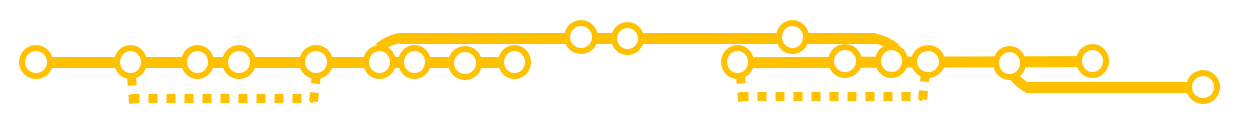


## Table of Contents
- **Visualizing the Temperature Data**
- **Mapping the Person's Trajectory**
- **Calculating the Heat Index**
- **Categorizing Heat Exposure**
- **Analyzing Travel Conditions by Mode**
- **Final Thoughts**

In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx

In [ ]:
TEMP_PATH = './project_heat'
SEC_TRAJ_PATH = './data/postproc/traj_sec_by_sec'

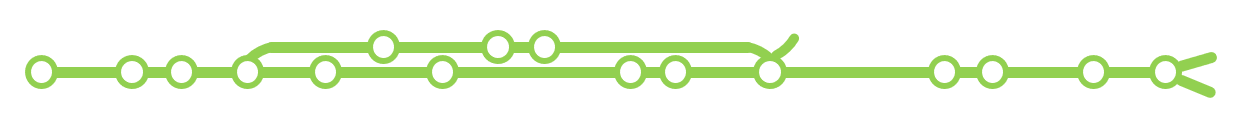

## 1. **Visualizing the Temperature Data**

Before diving into the transit data, let's first take a look at the temperature data we have. The temperature data is derived from land surface temperature from Landsat imagery.

In [ ]:
# Open the raster file
with rasterio.open(os.path.join(TEMP_PATH, 'lst.tif')) as src:
    # Read the raster data
    temperature_array = src.read(1)
    # Mask values below 50
    temperature_array = np.ma.masked_less(temperature_array, 50)
    # Get the bounds and other metadata for later use
    bounds = src.bounds
    transform = src.transform

# Plot the temperature to see it
fig, ax = plt.subplots(figsize=(10, 10))
show(temperature_array, ax=ax, transform=transform, cmap='inferno', vmin=50, vmax=100)
ax.set_title("Temperature Map")

# Add legend
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=50, vmax=100))
sm._A = []
fig.colorbar(sm, cax=cax, ticks=list(range(50, 101, 10)))
ax.axis('off')
plt.show()

The map above shows the temperature distribution in our study area. Areas with warmer colors indicate higher temperatures.


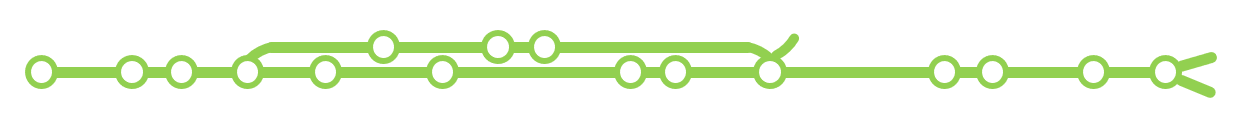

## 2. **Mapping the Person's Trajectory and Temperature**
Now, let's map out a person's trajectory and overlay it with temperature data to understand the conditions they experience during their journey.


Select a `trip_id` that you want to work with

In [ ]:
trip_id = 'trip_00003'

Now, we will obtain temperature data from the map above, using coordinates of our second-by-second trajectory:

In [ ]:
# read the trajectory file
traj = pd.read_csv(os.path.join(SEC_TRAJ_PATH, f'{trip_id}.csv'))
traj = gpd.GeoDataFrame(traj, geometry=gpd.points_from_xy(traj.lon, traj.lat))
traj = traj.set_crs('EPSG:4269')

# import all the temperature data
lst = rasterio.open(os.path.join(TEMP_PATH, 'lst.tif'))
rh = rasterio.open(os.path.join(TEMP_PATH, 'rh.bil'))
wind = rasterio.open(os.path.join(TEMP_PATH, 'wind.tif'))

# sample relative humidity
traj = traj.to_crs(rh.crs)
coords = [(x, y) for x, y in zip(traj['geometry'].x, traj['geometry'].y)]
traj['Humidity'] = [x[0] for x in rh.sample(coords)]

# sample temperature
traj = traj.to_crs(wind.crs)
coords = [(x, y) for x, y in zip(traj['geometry'].x, traj['geometry'].y)]
traj['Wind Speed'] = [x[0] for x in wind.sample(coords)]
traj['Wind Speed'] = 2.23693629 * traj['Wind Speed'] # to mph

# sample temperature
traj = traj.to_crs(lst.crs)
coords = [(x, y) for x, y in zip(traj['geometry'].x, traj['geometry'].y)]
traj['Temperature'] = [x[0] for x in lst.sample(coords)]

# Let's look at the processed trajectory data
traj.head(2)

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
traj = traj.to_crs('EPSG:3857')
traj.plot(ax=ax, column='Temperature', cmap='inferno', legend=True, markersize=10, vmin=50, vmax=100)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title("Temperature Trajectory")
ax.axis('off')
plt.show()

The map above shows the person's trajectory with color indicating the temperature at each point.



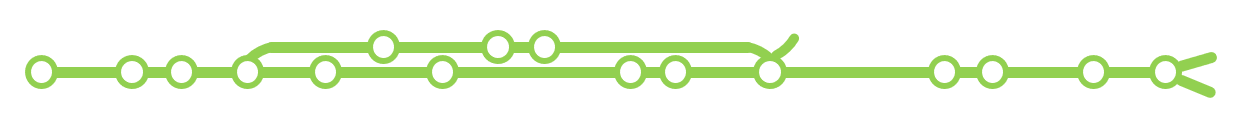

## 3. **Calculating the Heat Index**
The heat index is a measure that combines temperature and humidity to determine the apparent temperature or how humans perceive the temperature. Let's calculate the heat index for our trajectory and visualize it. In this case, we use the National Weather Service's definition: https://www.weather.gov/ama/heatindexopy

In [ ]:
def heat_index(T, RH):
    HI = (-42.379 + 
          2.04901523*T + 10.14333127*RH - 
          0.22475541*T*RH - 0.00683783*T*T - 0.05481717*RH*RH + 
          0.00122874*T*T*RH + 0.00085282*T*RH*RH - 
          0.00000199*T*T*RH*RH)
    if T < 80:
        HI = T
    elif RH < 13 and T > 80 and T < 120:
        ADJUSTMENT = ((13-RH)/4)*np.sqrt((17-abs(T-95))/17)
        HI = HI - ADJUSTMENT
    elif RH > 85 and T > 80 and T < 87:
        ADJUSTMENT = ((RH-85)/10) * ((87-T)/5)
        HI = HI + ADJUSTMENT
    if HI < 80:
        HI = 0.5 * (T + 61.0 + ((T-68.0)*1.2) + (RH*0.094))
    return(HI)

In [ ]:
def heat_cat(HI):
    cat = None
    if HI >= 130:
        cat = 'Extreme Danger'
    elif HI >= 105:
        cat = 'Danger'
    elif HI >= 90:
        cat = 'Extreme Caution'
    elif HI >= 80:
        cat = 'Caution'
    else:
        cat = 'Safe'
    return(cat)

Let's calculate the heat index for each location of our trip:

In [ ]:
traj['Heat Index'] = traj.apply(lambda x: heat_index(x.Temperature, x.Humidity), axis=1)
traj['heat_cat'] = [heat_cat(x) for x in traj['Heat Index']]
#
traj.head(2)

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
traj = traj.to_crs('EPSG:3857')
traj.plot(ax=ax, column='Heat Index', cmap='inferno', legend=True, markersize=10, vmin=50, vmax=100)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title("Heat Index Trajectory")
ax.axis('off')
plt.show()

The map above shows the person's trajectory with colors indicating different heat exposure categories.



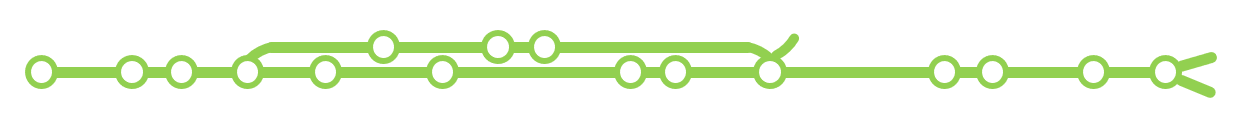

## 4. **Categorizing Heat Exposure**
Based on the heat index, we can categorize the conditions into different heat exposure categories. Let's visualize the person's trajectory based on these categories.


In [ ]:
# Define a color map for the heat categories
heat_colors = {
    'Safe': 'green',
    'Caution': 'yellow',
    'Extreme Caution': 'orange',
    'Danger': 'red',
    'Extreme Danger': 'purple'
}
# Map the heat categories to their colors
traj['color'] = traj['heat_cat'].map(heat_colors)
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
traj = traj.to_crs('EPSG:3857')
traj.plot(ax=ax, color=traj['color'], legend=True, markersize=10)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title("Heat Category Trajectory")

# Create a custom legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in heat_colors.items()]
ax.legend(handles=legend_patches, loc='upper right')
ax.axis('off')
plt.show()

The map above shows the person's trajectory with colors indicating different heat exposure categories.



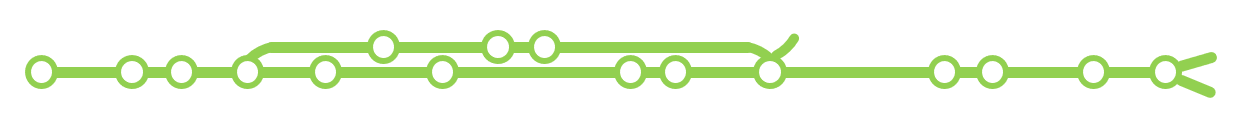

## 5. **Analyzing Travel Conditions by Mode**
Finally, let's break down the person's travel conditions by mode of transit and visualize the time spent in each heat exposure category.


In [ ]:
mode_dict = {
    'walk_ingress':'walking',
    'walking':'walking',
    'walk_egress':'walking',
    'waiting':'waiting',
    'riding':'riding'
}
traj['mode'] = [mode_dict[x] for x in traj['mode']]

Because most MARTA buses have air conditioning, so we will categorize all riding segments as "safe".

In [ ]:
traj.loc[traj['mode'] == 'riding', 'heat_cat'] = 'Safe'

We will then summarize the exposure:

In [ ]:
temp_summary = pd.DataFrame(traj.groupby(['mode', 'heat_cat']).size())
temp_summary.reset_index(inplace=True)
temp_summary.columns=['mode','heat_cat','time_minutes']
temp_summary['time_minutes'] = temp_summary['time_minutes']/60
temp_summary

In [ ]:
# Pivot the dataframe to get modes as index, heat categories as columns, and time_minutes as values
df_pivot = temp_summary.pivot(index='mode', columns='heat_cat', values='time_minutes').fillna(0)

# Define a color map for the heat categories
heat_colors = {
    'Safe': 'green',
    'Caution': 'yellow',
    'Extreme Caution': 'orange',
    'Danger': 'red',
    'Extreme Danger': 'purple'
}

# Plotting
ax = df_pivot.plot(kind='barh', stacked=True, color=[heat_colors[col] for col in df_pivot.columns], figsize=(8,4))
ax.set_ylabel('Time (minutes)')
ax.set_title("Person's Travel Condition by Mode")
ax.legend(title='Heat Category')

plt.tight_layout()
plt.show()

The chart above shows the time spent in each heat exposure category, broken down by mode of transit.



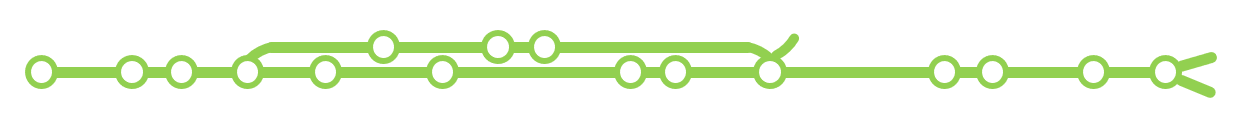

## 6. **Final Thoughts**

If you will present your findings to ARC, what would you suggest?
* Do you see any specific problems with our current system?
* What would you suggest on transit operation?
* What would you suggest on infrastructure planning in general?

After the analysis, let's tie it back to TransitSim 4.0. Back to the questions raised at the beginning of the lecture. Do you have different answers to the questions? 
* How is transit modeling different from other types of networks? What will happen if this analysis is to be done with a spatial graph?
* Is travel time enough for us to know all we need about a transit trip?
* What's the advantage of having second-by-second trajectory?